In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [28]:
import os
import pandas as pd
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import json
from collections import Counter
import time
import seaborn as sns
import pickle

In [3]:
import threading
threading.activeCount()

8

# Load

In [4]:
PATH = os.path.join(os.getcwd(), 'data/100k_a.csv')

In [5]:
df = pd.read_csv(PATH, names=['user_id', 'stream_id', 'streamer_name', 'start_time', 'stop_time'])

In [6]:
# Applying (user_id, streamer_name) edges
df['edge'] = list(zip(df['user_id'], df['streamer_name']))

# Basic logging

In [7]:
def df_stats(df):
    for col in df.columns:
        # print(f"{col} - # unique: {len(set(df[col]))}, # total: ")
        num_unique = len(set(df[col]))
        print(f"# of unique {col}:", "{:,}".format(num_unique))
        print(f"Average data per unique {col}:", (len(df) / num_unique))
        print("\n")
    print(f"Total # of Interactions:", "{:,}".format(len(df)))

In [8]:
df_stats(df)

# of unique user_id: 100,000
Average data per unique user_id: 30.51733


# of unique stream_id: 739,991
Average data per unique stream_id: 4.124013670436533


# of unique streamer_name: 162,625
Average data per unique streamer_name: 18.765460415065334


# of unique start_time: 6,148
Average data per unique start_time: 496.37817176317503


# of unique stop_time: 6,148
Average data per unique stop_time: 496.37817176317503


# of unique edge: 1,505,158
Average data per unique edge: 2.027516712531176


Total # of Interactions: 3,051,733


# Creating Graph
Bipartite graph of users + streamers

Two streamers are connected if a user visited both of them

# Network Analysis

In [9]:
from collections import defaultdict

In [10]:
# To counter
edge_weights = Counter(df['edge'])
assert sum(edge_weights[x] for x in edge_weights) == len(df)

In [11]:
# To weighted edge list
edge_list = []
for (u,v), weight in edge_weights.items():
    edge_list.append((u,v,weight))
assert len(edge_list) == len(edge_weights)

In [12]:
# Average count of user-item interactions
print(len(df) / len(edge_weights))

2.027516712531176


In [13]:
# Graph
G = nx.Graph()
G.add_weighted_edges_from(edge_list)

In [14]:
# Assert graph contains equal to users and streamers in df
assert len(G) == len(set(df['user_id'])) + len(set(df['streamer_name']))

In [22]:
# Projection
user_set = set(df['user_id'])
streamer_name_set = set(df['streamer_name'])

In [23]:
from networkx.algorithms import bipartite

In [24]:
start = time.time()
projected = bipartite.weighted_projected_graph(G, streamer_name_set)
print("Time taken:", time.time() - start)

Time taken: 783.036431312561


In [25]:
%%time
# old edges = 11048847
len(projected.edges)

CPU times: user 70.6 ms, sys: 12 ms, total: 82.7 ms
Wall time: 82.2 ms


11048847

In [31]:
nx.write_gpickle

<function networkx.readwrite.gpickle.write_gpickle(G, path, protocol=5)>

In [32]:
# Save the network as pickle
nx.write_gpickle(projected, 'projected_weighted.gpickle')

In [33]:
temp = nx.read_gpickle('projected_weighted.txt')

In [ ]:
temp.nodes

# Remove streamers with low connectivity

# Examples

In [85]:
edge_itr = iter(x for x in projected.edges(data=True) if x[2]['weight'] > 10)
for i in range(5):
    print(next(edge_itr))

('pleb_method', 'lexveldhuis', {'weight': 18})
('pleb_method', 'pokerstars', {'weight': 13})
('pleb_method', 'arlieshaban', {'weight': 18})
('pleb_method', 'easywithaces', {'weight': 18})
('pleb_method', 'allinpav', {'weight': 15})


# Partitioning into Communities

In [92]:
%%time
partition = community_louvain.best_partition(projected, weight='weight')

CPU times: user 7min, sys: 7.64 s, total: 7min 7s
Wall time: 7min 8s


In [94]:
# Unweighted projection has 364 different assignments
# Weighted projection has 334 different communities
len(set(partition.values()))

334

In [95]:
# save the partition
with open('weighted_communities.json', 'w') as fp:
    json.dump(partition, fp)

In [116]:
comm_to_streamers = defaultdict(list)
for streamer_name, community_id in partition.items():
    comm_to_streamers[community_id].append(streamer_name)

In [120]:
%%time
# Bar Graph of Community Sizes
counts = [len(streamers) for _, streamers in comm_to_streamers.items()]

CPU times: user 53 µs, sys: 1 µs, total: 54 µs
Wall time: 58.2 µs


<AxesSubplot:ylabel='Count'>

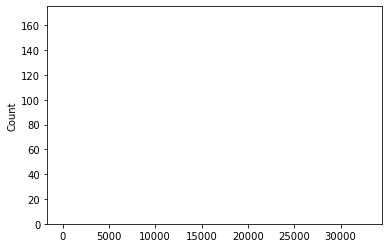

In [123]:
sns.histplot(counts)

# Visualizing the Graph

In [106]:
g_iter = iter(G.nodes)
sub_nodes = []
for i in range(100):
    sub_nodes.append(next(g_iter))
subgraph = G.subgraph(sub_nodes)

In [107]:
%%time
# draw the graph
pos = nx.spring_layout(subgraph)

CPU times: user 61.6 ms, sys: 16 ms, total: 77.6 ms
Wall time: 77.3 ms


NetworkXError: Node 'synqteam' has no position.

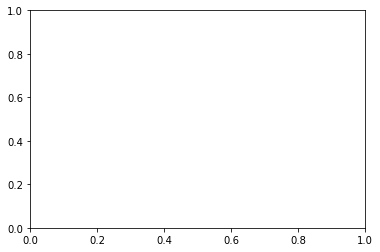

In [108]:
# draw the graph
# pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()